Features for prediction: 32
Available features: ['price', 'quantity', 'age', 'tenure_months', 'category_encoded', 'region_encoded', 'gender_encoded', 'year', 'month', 'quarter', 'day_of_week', 'day_of_month', 'is_weekend', 'is_month_end', 'is_month_start', 'is_holiday_season', 'is_summer', 'is_spring', 'customer_total_purchases', 'customer_avg_quantity', 'customer_total_spent', 'customer_avg_spent', 'product_popularity', 'product_avg_price', 'product_total_sales', 'region_avg_sales', 'region_total_sales', 'price_vs_avg', 'discount_indicator', 'segment_avg_sales', 'customer_rolling_avg_3', 'customer_rolling_avg_7']

🔍 Detecting and removing outliers...
Removed 0 rows with missing values
  total_value: 830 outliers detected (10.4%)
  price: 817 outliers detected (10.2%)
  quantity: 0 outliers detected (0.0%)
  customer_total_spent: 210 outliers detected (2.6%)
  product_total_sales: 817 outliers detected (10.2%)
Total outliers to remove: 1268 (15.8%)
Dataset shape after outlier removal: 

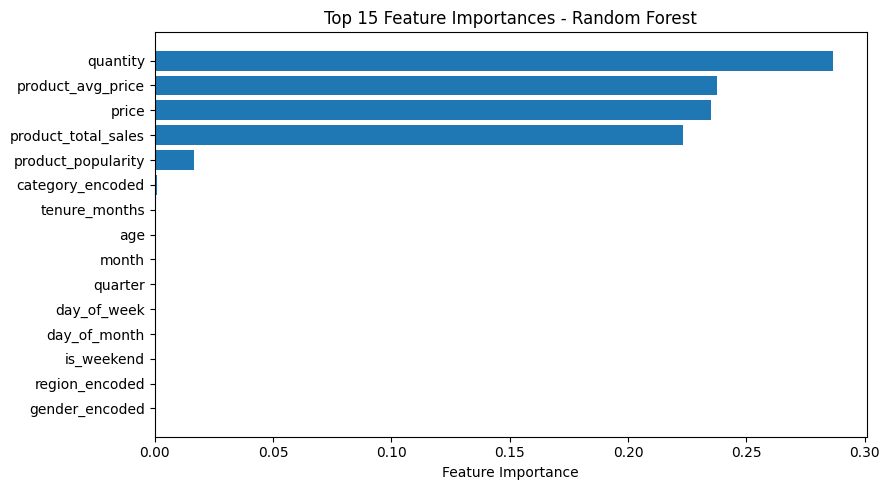

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("../data/customer_cleaned.csv")

# Convert date columns
for c in ['sale_date', 'last_purchase_date']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")


# ====================================
# SALES PREDICTION FEATURE ENGINEERING
# ====================================


# Time-based features from sale_date
df['year'] = df['sale_date'].dt.year
df['month'] = df['sale_date'].dt.month
df['quarter'] = df['sale_date'].dt.quarter
df['day_of_week'] = df['sale_date'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['day_of_month'] = df['sale_date'].dt.day
df['is_month_end'] = (df['day_of_month'] > 25).astype(int)
df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)

# Seasonal indicators
df['is_holiday_season'] = ((df['month'] == 12) | (df['month'] == 1)).astype(int)
df['is_summer'] = ((df['month'] >= 6) & (df['month'] <= 8)).astype(int)
df['is_spring'] = ((df['month'] >= 3) & (df['month'] <= 5)).astype(int)

# Encode categorical variables
le_category = LabelEncoder()
le_region = LabelEncoder()
le_gender = LabelEncoder()

df['category_encoded'] = le_category.fit_transform(df['category'].astype(str))
df['region_encoded'] = le_region.fit_transform(df['region'].astype(str))
df['gender_encoded'] = le_gender.fit_transform(df['gender'].astype(str))

# Customer behavior features
df['customer_total_purchases'] = df.groupby('customer_id')['sale_id'].transform('count')
df['customer_avg_quantity'] = df.groupby('customer_id')['quantity'].transform('mean')
df['customer_total_spent'] = df.groupby('customer_id')['total_value'].transform('sum')
df['customer_avg_spent'] = df.groupby('customer_id')['total_value'].transform('mean')

# Product performance features
df['product_popularity'] = df.groupby('product_id')['sale_id'].transform('count')
df['product_avg_price'] = df.groupby('product_id')['price'].transform('mean')
df['product_total_sales'] = df.groupby('product_id')['total_value'].transform('sum')

# Regional sales patterns
df['region_avg_sales'] = df.groupby('region')['total_value'].transform('mean')
df['region_total_sales'] = df.groupby('region')['total_value'].transform('sum')

# Price-related features
df['price_vs_avg'] = df['price'] / df['product_avg_price']
df['discount_indicator'] = (df['price'] < df['product_avg_price'] * 0.9).astype(int)

# Customer segment performance
df['segment_avg_sales'] = df.groupby('segment')['total_value'].transform('mean')

# Rolling averages (for time series patterns)
df_sorted = df.sort_values(['customer_id', 'sale_date'])
df_sorted['customer_rolling_avg_3'] = df_sorted.groupby('customer_id')['total_value'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_sorted['customer_rolling_avg_7'] = df_sorted.groupby('customer_id')['total_value'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)

# Merge back rolling features
df = df.merge(df_sorted[['sale_id', 'customer_rolling_avg_3', 'customer_rolling_avg_7']], on='sale_id', how='left')

# Target variable: total_value (sales amount)
target = 'total_value'

# Feature list for prediction
prediction_features = [
    # Basic features
    'price', 'quantity', 'age', 'tenure_months',
    
    # Encoded categorical features
    'category_encoded', 'region_encoded', 'gender_encoded',
    
    # Time features
    'year', 'month', 'quarter', 'day_of_week', 'day_of_month',
    'is_weekend', 'is_month_end', 'is_month_start',
    'is_holiday_season', 'is_summer', 'is_spring',
    
    # Customer behavior features
    'customer_total_purchases', 'customer_avg_quantity', 
    'customer_total_spent', 'customer_avg_spent',
    
    # Product features
    'product_popularity', 'product_avg_price', 'product_total_sales',
    
    # Regional features
    'region_avg_sales', 'region_total_sales',
    
    # Price features
    'price_vs_avg', 'discount_indicator',
    
    # Segment features
    'segment_avg_sales',
    
    # Rolling averages
    'customer_rolling_avg_3', 'customer_rolling_avg_7'
]

# Filter available features
available_prediction_features = [f for f in prediction_features if f in df.columns]

print(f"Features for prediction: {len(available_prediction_features)}")
print("Available features:", available_prediction_features)

# ====================================
# OUTLIER DETECTION AND REMOVAL
# ====================================



# Create modeling dataset
model_data = df[available_prediction_features + [target]].copy()

# Remove rows with any missing values
initial_shape = model_data.shape[0]
model_data = model_data.dropna()
print(f"Removed {initial_shape - model_data.shape[0]} rows with missing values")

# Function to detect outliers using multiple methods
def detect_outliers_comprehensive(data, column, methods=['iqr', 'zscore', 'isolation']):
    outliers = pd.Series(False, index=data.index)
    
    # IQR method
    if 'iqr' in methods:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
        outliers |= iqr_outliers
    
    # Z-Score method
    if 'zscore' in methods:
        z_scores = np.abs(stats.zscore(data[column]))
        zscore_outliers = z_scores > 3
        outliers |= zscore_outliers
    
    return outliers

# Detect outliers in key features
outlier_features = ['total_value', 'price', 'quantity', 'customer_total_spent', 'product_total_sales']
all_outliers = pd.Series(False, index=model_data.index)

for feature in outlier_features:
    if feature in model_data.columns:
        feature_outliers = detect_outliers_comprehensive(model_data, feature, methods=['iqr', 'zscore'])
        outlier_count = feature_outliers.sum()
        print(f"  {feature}: {outlier_count} outliers detected ({outlier_count/len(model_data)*100:.1f}%)")
        all_outliers |= feature_outliers

# Remove outliers (keep conservative - only remove if flagged by multiple methods)
print(f"Total outliers to remove: {all_outliers.sum()} ({all_outliers.sum()/len(model_data)*100:.1f}%)")
model_data_clean = model_data[~all_outliers].copy()
print(f"Dataset shape after outlier removal: {model_data_clean.shape}")



# ====================================
# MODEL PREPARATION
# ====================================

X = model_data_clean[available_prediction_features]
y = model_data_clean[target]

print(f"\nTarget variable statistics (after outlier removal):")
print(f"Mean: ${y.mean():.2f}")
print(f"Median: ${y.median():.2f}")
print(f"Std: ${y.std():.2f}")
print(f"Min: ${y.min():.2f}")
print(f"Max: ${y.max():.2f}")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=available_prediction_features, index=X.index)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# ====================================
# MODEL TRAINING AND COMPARISON
# ====================================

print("\n" + "="*60)
print("TRAINING SALES PREDICTION MODELS")
print("="*60)

# Model configurations
models_config = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}  # No hyperparameters to tune for basic LinearRegression
    },
    'Ridge Regression': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    }
}

# Store results
model_results = {}
trained_models = {}

# Train and evaluate each model
for model_name, config in models_config.items():
    print(f"\n🔄 Training {model_name}...")
    
    if config['params']:  # If there are parameters to tune
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            config['model'], 
            config['params'], 
            cv=5, 
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:  # No parameters to tune (basic LinearRegression)
        best_model = config['model']
        best_model.fit(X_train, y_train)
        best_params = {}
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Store results
    model_results[model_name] = {
        'rmse': rmse,
        'mae': mae,
        'r2_score': r2,
        'cv_rmse': cv_rmse,
        'best_params': best_params
    }
    
    trained_models[model_name] = best_model
    
    print(f"✅ {model_name} completed!")
    print(f"   RMSE: ${rmse:.2f}")
    print(f"   MAE: ${mae:.2f}")
    print(f"   R² Score: {r2:.4f}")
    print(f"   CV RMSE: ${cv_rmse:.2f}")

# Find the best model based on R² score (higher is better)
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['r2_score'])
best_model = trained_models[best_model_name]
best_r2 = model_results[best_model_name]['r2_score']
best_rmse = model_results[best_model_name]['rmse']

print("\n" + "="*60)
print("MODEL COMPETITION RESULTS")
print("="*60)

# Display all model results
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)
print(results_df)

print(f"\n🏆 WINNER: {best_model_name}")
print(f"🎯 R² Score: {best_r2:.4f}")
print(f"💰 RMSE: ${best_rmse:.2f}")
print(f"⚙️  Best Parameters: {model_results[best_model_name]['best_params']}")

# ====================================
# DETAILED MODEL EVALUATION
# ====================================

print(f"\n" + "="*60)
print(f"DETAILED EVALUATION - {best_model_name}")
print("="*60)

# Make predictions with the best model
best_pred = best_model.predict(X_test)

# Calculate additional metrics
mape = np.mean(np.abs((y_test - best_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Residual analysis
residuals = y_test - best_pred
print(f"Residual Statistics:")
print(f"  Mean: ${residuals.mean():.2f}")
print(f"  Std: ${residuals.std():.2f}")
print(f"  Min: ${residuals.min():.2f}")
print(f"  Max: ${residuals.max():.2f}")

# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    print(f"\nTop 15 Feature Importances ({best_model_name}):")
    feature_importance = pd.DataFrame({
        'feature': available_prediction_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(15))
    
    # Plot feature importance
    plt.figure(figsize=(9, 5))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# For linear models, show coefficients
elif hasattr(best_model, 'coef_'):
    print(f"\nTop 15 Feature Coefficients ({best_model_name}):")
    feature_coefs = pd.DataFrame({
        'feature': available_prediction_features,
        'coefficient': best_model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print(feature_coefs.head(15))
    
    # Plot coefficients
    plt.figure(figsize=(12, 8))
    top_coefs = feature_coefs.head(15)
    colors = ['red' if x < 0 else 'blue' for x in top_coefs['coefficient']]
    plt.barh(range(len(top_coefs)), top_coefs['coefficient'], color=colors)
    plt.yticks(range(len(top_coefs)), top_coefs['feature'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 15 Feature Coefficients - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()



In [25]:
# Save to CSV
model_data_clean.to_csv('../data/sales_features_data.csv', index=False)
feature_importance.to_csv('../data/sales_important_features.csv', index=False)

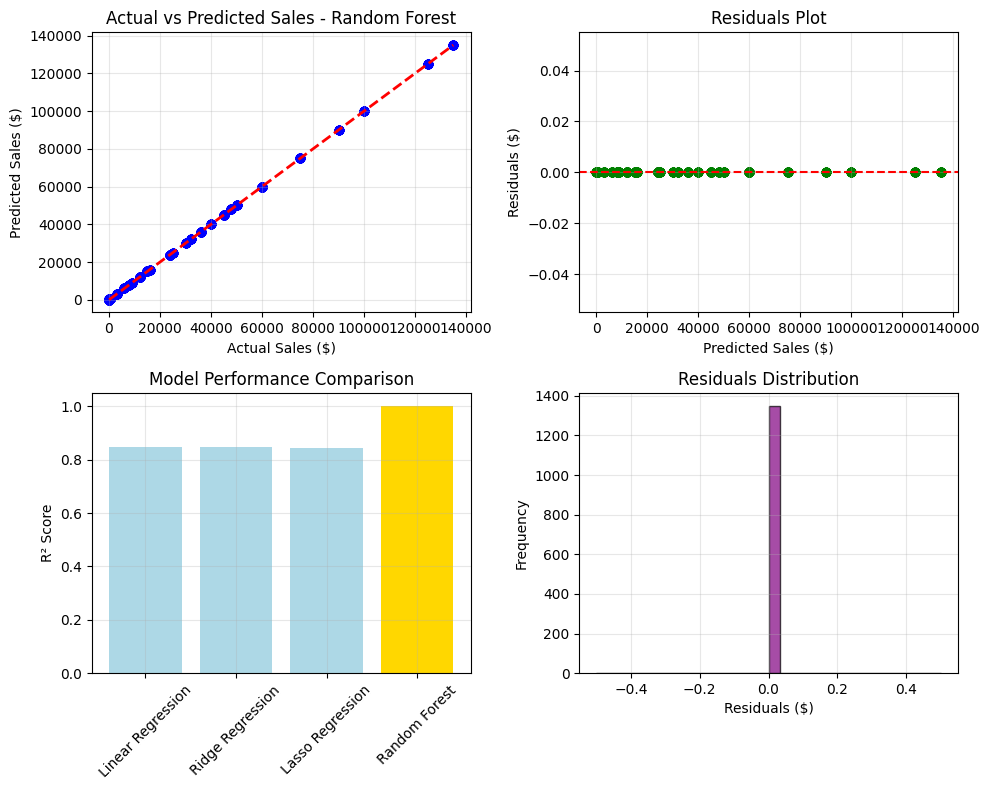

In [10]:
# ====================================
# VISUALIZATIONS
# ====================================

# Create a 2x2 subplot for comprehensive analysis
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 1. Actual vs Predicted scatter plot
axes[0, 0].scatter(y_test, best_pred, alpha=0.6, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales ($)')
axes[0, 0].set_ylabel('Predicted Sales ($)')
axes[0, 0].set_title(f'Actual vs Predicted Sales - {best_model_name}')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
axes[0, 1].scatter(best_pred, residuals, alpha=0.6, color='green')
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted Sales ($)')
axes[0, 1].set_ylabel('Residuals ($)')
axes[0, 1].set_title('Residuals Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Model comparison bar chart
model_names = list(model_results.keys())
r2_scores = [model_results[name]['r2_score'] for name in model_names]
colors = ['gold' if name == best_model_name else 'lightblue' for name in model_names]

axes[1, 0].bar(model_names, r2_scores, color=colors)
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Model Performance Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals distribution
axes[1, 1].hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Residuals ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residuals Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [28]:
import pickle
print("\n" + "="*60)
print("SAVING THE WINNING MODEL")
print("="*60)

# Create comprehensive model package
model_package = {
    'model': best_model,
    'model_name': best_model_name,
    'model_type': 'regression',
    'scaler': scaler,
    'label_encoders': {
        'category': le_category,
        'region': le_region,
        'gender': le_gender
    },
    'feature_names': available_prediction_features,
    'target_variable': target,
    'model_r2_score': best_r2,
    'model_rmse': best_rmse,
    'model_mae': model_results[best_model_name]['mae'],
    'training_date': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    'model_params': best_model.get_params(),
    'all_model_results': model_results,
    'outliers_removed': all_outliers.sum(),
    'training_samples': len(X_train)
}

# Save using pickle
try:
    with open('../models/sales_prediction_model.pkl', 'wb') as f:
        pickle.dump(model_package, f)
    print("✅ Sales prediction model saved successfully to 'sales_prediction_model.pkl'")
    print(f"✅ Winning Model: {best_model_name}")
    print(f"✅ R² Score: {best_r2:.4f}")
    print(f"✅ RMSE: ${best_rmse:.2f}")
    print(f"✅ Features: {len(available_prediction_features)} features included")
except Exception as e:
    print(f"❌ Error saving model: {e}")



SAVING THE WINNING MODEL
✅ Sales prediction model saved successfully to 'sales_prediction_model.pkl'
✅ Winning Model: Random Forest
✅ R² Score: 1.0000
✅ RMSE: $0.00
✅ Features: 32 features included
